# URL Classifier

### **Imports**

**General Imports**

In [715]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import regex as re
from scipy.stats import randint

**Machine Learning Imports**

In [1298]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score  
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC, SVR
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
download("wordnet")
from wordcloud import WordCloud
from pickle import dump

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ferna\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### **Global variables**

In [1297]:
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(n_estimators = 20, random_state = 42)
xg = XGBClassifier(n_estimators = 20, random_state = 42)
bernoulli = BernoulliNB()
svm = SVC(kernel='linear', random_state=42)
knn = KNeighborsClassifier()

models = [lr, dt, rf, gb, xg, bernoulli, svm, knn]

### **Loading data**

In [1299]:
url = 'https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv'
df = pd.read_csv(url)
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [1300]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2999 non-null   object
 1   is_spam  2999 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 26.5+ KB


### **Data Cleaning**

In [1301]:
#Checking for duplicates
df.duplicated().sum()

630

In [1302]:
#Dropping duplicates
df = df.drop_duplicates()

In [1303]:
df = df.reset_index(inplace=False, drop=True)
df.shape

(2369, 2)

In [1306]:
#Checking for null values
df.isnull().sum()

url        0
is_spam    0
dtype: int64

### **EDA**

In [1307]:
#Spam distribution
df.is_spam.value_counts()

is_spam
False    2125
True      244
Name: count, dtype: int64

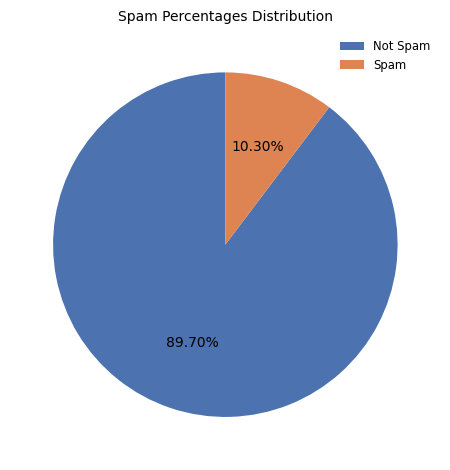

In [1308]:
legend = ['Not Spam', 'Spam']
colours = sns.color_palette('deep')[0:len(legend)]
df.is_spam.value_counts().plot(kind='pie', autopct='%1.2f%%', startangle=90, colors=colours, labels=None)
plt.ylabel('')
plt.title('Spam Percentages Distribution', fontsize='medium')
plt.legend(legend, frameon=False, fontsize='small', loc='best')
plt.tight_layout()
plt.show()

### **Models based on the URL**

#### **Preparing the data**

In [1309]:
df_svm = df.copy()

In [1310]:
df_svm.is_spam = df_svm.is_spam.astype(int)

In [1311]:
#Pre processing text
def preprocess_text(text):
    # Remove any character that is not a letter (a-z) or white space ( )
    text = re.sub(r'[^a-z ]', " ", text)
    
    # Remove white spaces
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Multiple white spaces into one
    text = re.sub(r'\s+', " ", text.lower())

    # Remove tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

df_svm['url'] = df_svm.url.apply(lambda x: preprocess_text(x))

In [1312]:
#Lemmatizing the text in the url's
lemmatizer = WordNetLemmatizer()

#download('stopwords')
#stop_words = stopwords.words('english')

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    #tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

df_svm['url'] = df_svm['url'].apply(lemmatize_text)
df_svm.head()

,url,is_spam
0,"[http, briefingday, list, manage, unsubscribe]",1
1,"[http, hvper]",1
2,"[http, briefingday]",1
3,"[http, briefingday, commentform]",0
4,"[http, briefingday]",1


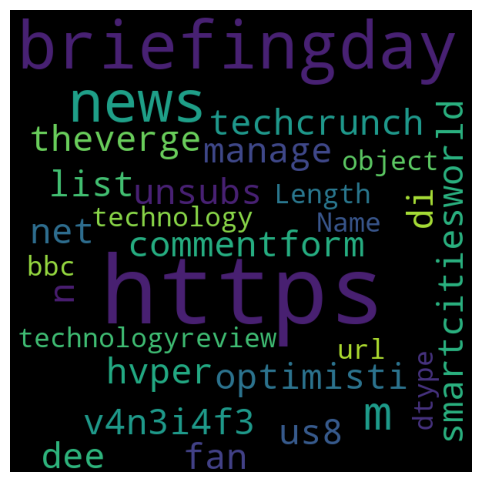

In [1313]:
wordcloud = WordCloud(width=600, height=600, background_color="black", max_words=1000, min_font_size=20, random_state = 42).generate(str(df['url']))
fig = plt.figure(figsize=(6,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [1314]:
#Transforming data into array
vector = TfidfVectorizer()

tokens = df_svm.url.apply(lambda x: ' '.join(x))
X = vector.fit_transform(tokens).toarray()
y = df_svm['is_spam']
X[:4]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [1315]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train data:\nX:', X_train.shape, 'y:', y_train.shape)
print('Test data:\nX:', X_test.shape, 'y:', y_test.shape)

Train data:
X: (1895, 4741) y: (1895,)
Test data:
X: (474, 4741) y: (474,)


#### **Training the models**

Fitting LogisticRegression...
F1 Score on train data is 0.45
F1 Score on test data is 0.49

Fitting DecisionTreeClassifier...
F1 Score on train data is 0.98
F1 Score on test data is 0.68

Fitting RandomForestClassifier...
F1 Score on train data is 0.98
F1 Score on test data is 0.70

Fitting GradientBoostingClassifier...
F1 Score on train data is 0.46
F1 Score on test data is 0.50

Fitting XGBClassifier...
F1 Score on train data is 0.66
F1 Score on test data is 0.70

Fitting BernoulliNB...
F1 Score on train data is 0.19
F1 Score on test data is 0.10

Fitting SVC...
F1 Score on train data is 0.87
F1 Score on test data is 0.72

Fitting KNeighborsClassifier...
F1 Score on train data is 0.64
F1 Score on test data is 0.47



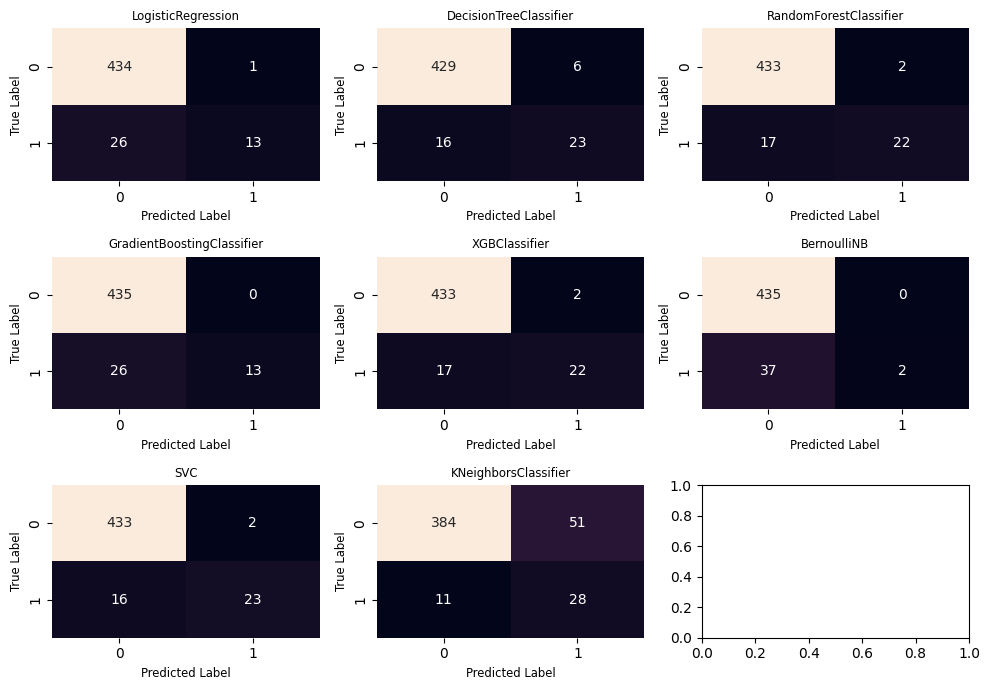

In [1336]:
models_dict = []

# Determine the number of rows and columns for the grid
num_cols = 3
num_rows = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 7))

# Flatten the axes if there is only one row
if num_rows == 1:
    axes = axes.reshape(1, -1)

for i, model in enumerate(models):
    print(f'Fitting {model.__class__.__name__}...')
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    f1_train = f1_score(y_train, y_train_pred)
    f1_test = f1_score(y_test, y_test_pred)
    print(f'F1 Score on train data is {f1_train:.2f}')
    print(f'F1 Score on test data is {f1_test:.2f}\n')

    cm = confusion_matrix(y_test, y_test_pred)
    cm_df = pd.DataFrame(cm)

    # Plot the confusion matrix in the grid
    sns.heatmap(cm_df, annot=True, fmt="d", cbar=False, ax=axes[i // num_cols, i % num_cols])
    axes[i // num_cols, i % num_cols].set_title(f'{model.__class__.__name__}', fontsize='small')
    axes[i // num_cols, i % num_cols].set_xlabel('Predicted Label', fontsize='small')
    axes[i // num_cols, i % num_cols].set_ylabel('True Label', fontsize='small')

    models_dict.append({'Model': model.__class__.__name__, 'F1 Score Train': f1_train, 'F1 Score Test': f1_test})
    
plt.tight_layout()
plt.show()

The SVM model was the one with the best performance on the test dataset, so we will try to optimise it.

#### **Optimizing the SVM model**

In [1320]:
hyperparams = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'shrinking': [True, False],
    'C': randint(1, 100)
}

svm_op = RandomizedSearchCV(model, hyperparams, scoring='f1_macro', cv=5, n_jobs=8, random_state=42)
svm_op

RandomizedSearchCV(cv=5, estimator=SVC(kernel='linear', random_state=42),
                   n_jobs=8,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000196FF723160>,
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid'],
                                        'shrinking': [True, False]},
                   random_state=42, scoring='f1_macro')

In [1321]:
svm_op.fit(X_train, y_train)
print("Best Hyperparameters:", svm_op.best_params_)

Best Hyperparameters: {'C': 72, 'gamma': 'scale', 'kernel': 'linear', 'shrinking': True}


In [1322]:
svm_best = svm_op.best_estimator_

In [1323]:
svm_best.fit(X_train, y_train)
y_pred_train = svm_best.predict(X_train)
y_pred_test = svm_best.predict(X_test)

In [1324]:
f1_train = f1_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)
print(f'F1 Score on train data is {f1_train:.2f}')
print(f'F1 Score on test data is {f1_test:.2f}\n')

F1 Score on train data is 0.98
F1 Score on test data is 0.61



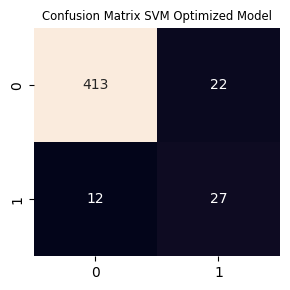

In [1325]:
cm = confusion_matrix(y_test, y_pred_test)
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(3,3))
sns.heatmap(cm_df, annot=True, fmt="d", cbar=False)
plt.title('Confusion Matrix SVM Optimized Model', fontsize='small')
plt.tight_layout()
plt.show()

The Support Vector Machine model showed a F1 Score on test data of 0.72, after optimising it, the F1 Score went down to 0.61. We will extract some features from the dataset to run other models.

### **Models based on Feature Extraction**

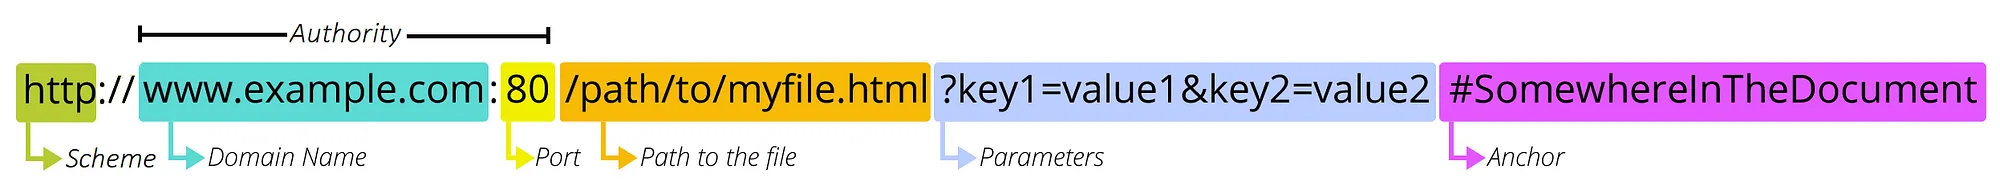
From https://medium.com/nerd-for-tech/url-feature-engineering-and-classification-66c0512fb34d

The dataset contains two columns: the url and if the url is spam or not. In order to understand the patterns of the url's that are classified as spam or not spam, the following features were extracted from the dataset.

| Feature  | Description |
|:--------|:---------|
|url_length   |Number of characters in the url   |
has_subscribe   |  URL has the words subscribe   |contains_hash   |  URL has a hash ('#') 
|  num_digits   |  Number of digits   |
|  secure_connection   |  URL has https   |
|  num_parameters   | Number of parameters (after '?')  |
|  num_fragments   |  Number of fragments (after '#')   |
|  num_subdomains   |  Number of subdomains s |
|  entropy   |  Disorder of the URL   |  |

In [1326]:
df_test = df.copy()

In [1328]:
df_test.is_spam.value_counts()

is_spam
False    2125
True      244
Name: count, dtype: int64

In [1329]:
#Number of digits in the url
def count_digits(string):
    i = 0
    for char in string:
        if char.isdigit():
            i += 1
    return i

#Entropy
def entropy(url):
    string = url.strip().lower()
    prob = [string.count(c) / len(string) for c in set(string)]
    entropy = -sum(p * math.log2(p) for p in prob)
    return entropy

In [1330]:
df_test['url_lenght'] = df_test.url.apply(lambda x: len(x))
df_test['has_subscribe'] = df_test.url.apply(lambda x: 1 if 'subscribe' in x else 0)
df_test['contains_hash'] = df_test.url.apply(lambda x: 1 if '#' in x else 0)
df_test['num_digits'] = df_test.url.apply(lambda x: count_digits(str(x)))
df_test['secure_connection'] = df_test.url.apply(lambda x: 1 if 'https' in x else 0)
df_test['entropy'] = df_test.url.apply(lambda x: entropy(x))
df_test['num_parameters'] = df_test.url.apply(lambda x: len(x.split('&')) - 1)
df_test['num_fragments'] = df_test.url.apply(lambda x: len(x.split('#')) -1)
df_test['num_subdomains'] = df_test.url.apply(lambda x: len(x.split('http')[-1].split('//')[-1].split('/')) - 1)

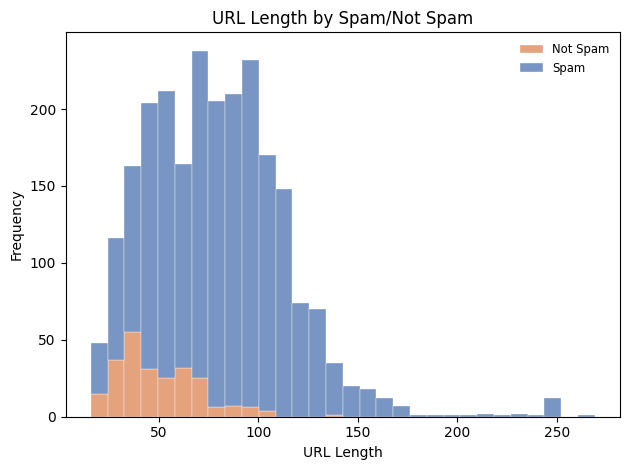

In [1331]:
sns.histplot(data=df_test, x='url_lenght', hue='is_spam', multiple='stack', bins=30, lw=0.25, edgecolor='white', palette='deep')
plt.xlabel('URL Length')
plt.ylabel('Frequency')
plt.title('URL Length by Spam/Not Spam')
plt.legend(legend, frameon=False, fontsize='small', loc='best')
plt.tight_layout()
plt.show()

#### **Preparing the data**

In [1337]:
df_test.dtypes

url                   object
is_spam                 bool
url_lenght             int64
has_subscribe          int64
contains_hash          int64
num_digits             int64
secure_connection      int64
entropy              float64
num_parameters         int64
num_fragments          int64
num_subdomains         int64
dtype: object

In [1338]:
#convert bool to integer
df_test.is_spam = df_test.is_spam.astype(int)

In [1339]:
#Dataset split
X = df_test.drop(['url','is_spam'], axis=1)
y = df_test['is_spam']

In [1340]:
X.head(3)

,url_lenght,has_subscribe,contains_hash,num_digits,secure_connection,entropy,num_parameters,num_fragments,num_subdomains
0,51,1,0,1,1,4.385195,0,0,1
1,22,0,0,0,1,3.663533,0,0,1
2,34,0,0,4,1,4.359378,0,0,2


In [1341]:
num_columns = ['url_lenght', 'has_subscribe', 'contains_hash', 'num_digits', 'secure_connection', 'entropy', 'num_parameters',
       'num_fragments', 'num_subdomains']
scaler = StandardScaler()
X[num_columns] = scaler.fit_transform(X[num_columns])

In [1342]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1343]:
print('Train data:\nX:', X_train.shape, 'y:', y_train.shape)
print('Test data:\nX:', X_test.shape, 'y:', y_test.shape)

Train data:
X: (1895, 9) y: (1895,)
Test data:
X: (474, 9) y: (474,)


#### **Training the models**

Fitting LogisticRegression...
F1 Score on train data is 0.14
F1 Score on test data is 0.19

Fitting DecisionTreeClassifier...
F1 Score on train data is 0.98
F1 Score on test data is 0.37

Fitting RandomForestClassifier...
F1 Score on train data is 0.98
F1 Score on test data is 0.38

Fitting GradientBoostingClassifier...
F1 Score on train data is 0.18
F1 Score on test data is 0.19

Fitting XGBClassifier...
F1 Score on train data is 0.54
F1 Score on test data is 0.39

Fitting BernoulliNB...
F1 Score on train data is 0.45
F1 Score on test data is 0.39

Fitting SVC...
F1 Score on train data is 0.16
F1 Score on test data is 0.19

Fitting KNeighborsClassifier...
F1 Score on train data is 0.56
F1 Score on test data is 0.43



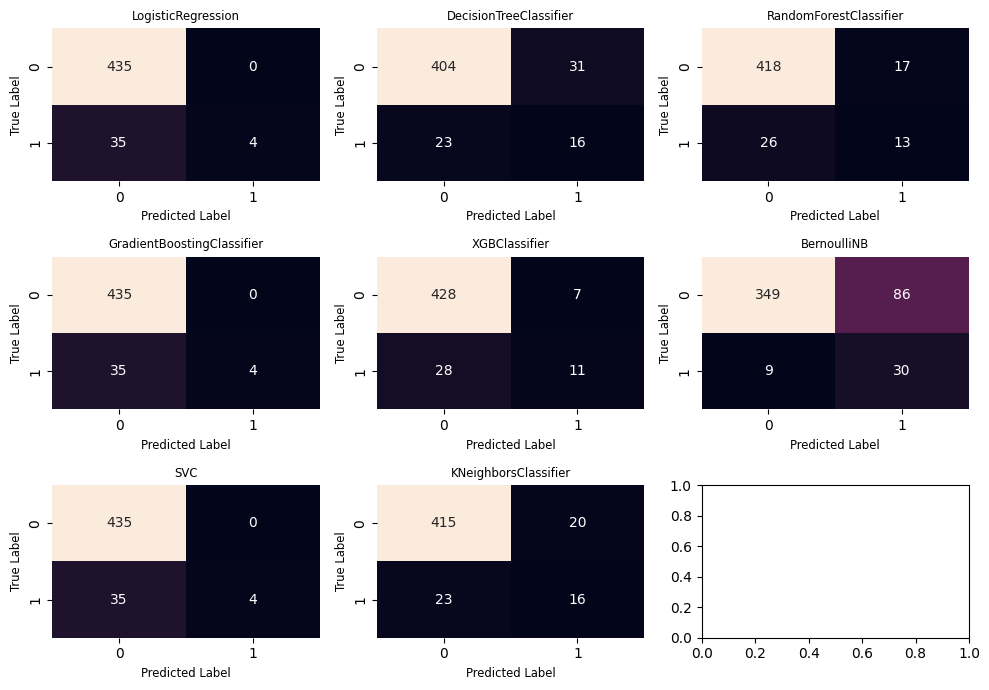

In [1344]:
models_dict = []

# Determine the number of rows and columns for the grid
num_cols = 3
num_rows = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 7))

# Flatten the axes if there is only one row
if num_rows == 1:
    axes = axes.reshape(1, -1)

for i, model in enumerate(models):
    print(f'Fitting {model.__class__.__name__}...')
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    f1_train = f1_score(y_train, y_train_pred)
    f1_test = f1_score(y_test, y_test_pred)
    print(f'F1 Score on train data is {f1_train:.2f}')
    print(f'F1 Score on test data is {f1_test:.2f}\n')

    cm = confusion_matrix(y_test, y_test_pred)
    cm_df = pd.DataFrame(cm)

    # Plot the confusion matrix in the grid
    sns.heatmap(cm_df, annot=True, fmt="d", cbar=False, ax=axes[i // num_cols, i % num_cols])
    axes[i // num_cols, i % num_cols].set_title(f'{model.__class__.__name__}', fontsize='small')
    axes[i // num_cols, i % num_cols].set_xlabel('Predicted Label', fontsize='small')
    axes[i // num_cols, i % num_cols].set_ylabel('True Label', fontsize='small')

    models_dict.append({'Model': model.__class__.__name__, 'F1 Score Train': f1_train, 'F1 Score Test': f1_test})
    
plt.tight_layout()
plt.show()


**Comparing the models**

In [1345]:
models_df = pd.DataFrame(models_dict)
models_df

,Model,F1 Score Train,F1 Score Test
0,LogisticRegression,0.144144,0.186047
1,DecisionTreeClassifier,0.977778,0.372093
2,RandomForestClassifier,0.977995,0.376812
3,GradientBoostingClassifier,0.177778,0.186047
4,XGBClassifier,0.536082,0.385965
5,BernoulliNB,0.450402,0.387097
6,SVC,0.160714,0.186047
7,KNeighborsClassifier,0.563798,0.426667


In [1346]:
models_melted = pd.melt(models_df, id_vars=['Model'], var_name='Metric', value_name='Value')

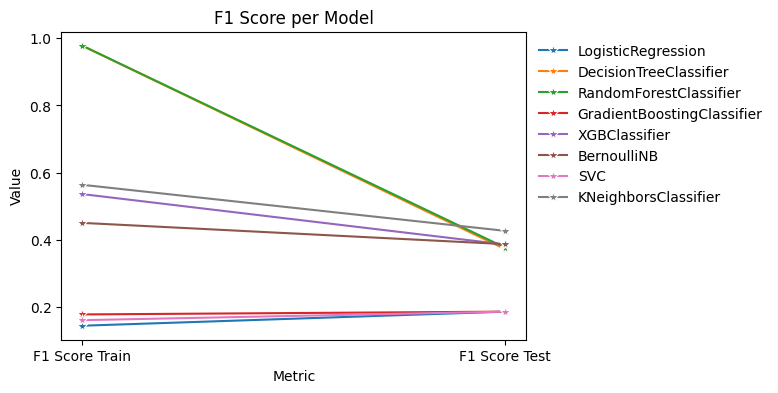

In [1349]:
plt.figure(figsize=(6,4))
sns.lineplot(x='Metric', y='Value', hue='Model', data=models_melted, marker='*', markersize=8)
plt.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1))
plt.title('F1 Score per Model')
plt.show()

None of the models performed well with the feature extraction.

#### **Deep Learning**

In [1231]:
import keras
import tensorflow as tf
from keras import layers
from tensorflow import data as tf_data
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.utils import to_categorical

In [1350]:
df_dl = df_test.copy()

In [1351]:
df_dl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2369 entries, 0 to 2368
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   url                2369 non-null   object 
 1   is_spam            2369 non-null   int32  
 2   url_lenght         2369 non-null   int64  
 3   has_subscribe      2369 non-null   int64  
 4   contains_hash      2369 non-null   int64  
 5   num_digits         2369 non-null   int64  
 6   secure_connection  2369 non-null   int64  
 7   entropy            2369 non-null   float64
 8   num_parameters     2369 non-null   int64  
 9   num_fragments      2369 non-null   int64  
 10  num_subdomains     2369 non-null   int64  
dtypes: float64(1), int32(1), int64(8), object(1)
memory usage: 194.5+ KB


In [1352]:
num_columns = ['url_lenght', 'has_subscribe', 'contains_hash', 'num_digits', 'secure_connection', 'entropy', 'num_parameters',
       'num_fragments', 'num_subdomains']
scaler = StandardScaler()
X = df_dl.drop(['url', 'is_spam'], axis=1)
y = df_dl['is_spam']
X[num_columns] = scaler.fit_transform(X[num_columns])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1353]:
model = Sequential()    
model.add(Dense(256, activation = 'relu', input_shape=(9,)))    
model.add(Dense(128, activation = 'relu'))    
model.add(Dense(64, activation = 'relu'))    
model.add(Dense(32, activation = 'relu'))    
model.add(Dense(16, activation = 'relu'))    
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy' ,optimizer='adam' , metrics = 'accuracy' )

In [1354]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 256)               2560      
                                                                 
 dense_55 (Dense)            (None, 128)               32896     
                                                                 
 dense_56 (Dense)            (None, 64)                8256      
                                                                 
 dense_57 (Dense)            (None, 32)                2080      
                                                                 
 dense_58 (Dense)            (None, 16)                528       
                                                                 
 dense_59 (Dense)            (None, 1)                 17        
                                                                 
Total params: 46337 (181.00 KB)
Trainable params: 463

In [1355]:
history = model.fit(X_train, y_train, epochs=50, validation_split=0.3, batch_size = 128)

Epoch 1/50
11/11 [==============================] - 3s 47ms/step - loss: 0.6790 - accuracy: 0.7149 - val_loss: 0.6307 - val_accuracy: 0.8981
Epoch 2/50
11/11 [==============================] - 0s 11ms/step - loss: 0.5729 - accuracy: 0.8997 - val_loss: 0.4831 - val_accuracy: 0.8981
Epoch 3/50
11/11 [==============================] - 0s 10ms/step - loss: 0.4010 - accuracy: 0.8997 - val_loss: 0.3225 - val_accuracy: 0.8981
Epoch 4/50
11/11 [==============================] - 0s 11ms/step - loss: 0.2871 - accuracy: 0.9005 - val_loss: 0.2642 - val_accuracy: 0.8998
Epoch 5/50
11/11 [==============================] - 0s 11ms/step - loss: 0.2619 - accuracy: 0.8997 - val_loss: 0.2594 - val_accuracy: 0.8998
Epoch 6/50
11/11 [==============================] - 0s 10ms/step - loss: 0.2606 - accuracy: 0.9012 - val_loss: 0.2548 - val_accuracy: 0.8998
Epoch 7/50
11/11 [==============================] - 0s 11ms/step - loss: 0.2542 - accuracy: 0.9012 - val_loss: 0.2519 - val_accuracy: 0.8998
Epoch 8/50
11

In [1356]:
_, acc = model.evaluate(X_test, y_test)
print('Model accuracy:', acc)

15/15 [==============================] - 0s 3ms/step - loss: 0.2113 - accuracy: 0.9219
Model accuracy: 0.9219409227371216


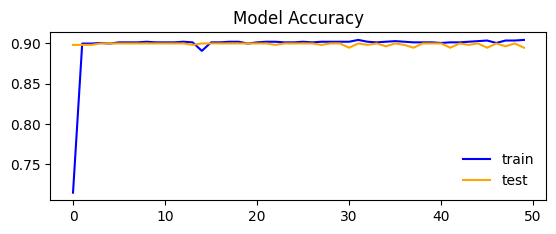

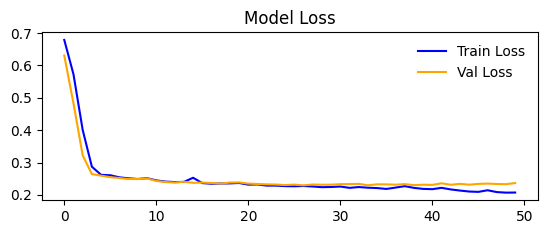

In [1357]:
plt.subplot(211)
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.title('Model Accuracy')
plt.legend(frameon=False, loc='best')
plt.show()

plt.subplot(212)
plt.plot(history.history['loss'], color='blue', label='Train Loss')
plt.plot(history.history['val_loss'], color='orange', label='Val Loss')
plt.title('Model Loss')
plt.legend(frameon=False, loc='best')
plt.savefig("losses.jpg")
plt.show()

### **Saving the best model**

In [ ]:
dump(history, open("../models/deep_learning_url_classifier.sav", "wb"))